In [1]:
import context

from G4EPP import api

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.colors import LogNorm

from scipy.signal import savgol_filter

from scipy.special import gamma

Api = api()

5.398e+05 /cm2/s/sr
7.357e+05 /cm2/s/sr
1.712e+06 /cm2/s/sr


f(E)    AE* = 300-500    500-700    900-1300

f(10 keV): 2.438e+07    2.252e+07    5.893e+07
f(20 keV): 1.077e+07    1.203e+07    2.843e+07
f(50 keV): 2.972e+06    4.482e+06    9.647e+06
f(100 keV): 8.003e+05    1.644e+06    3.516e+06
f(200 keV): 1.161e+05    3.774e+05    9.021e+05
f(500 keV): 1.133e+03    1.117e+04    4.602e+04
f(1000 keV): 1.164e+00    6.016e+01    7.130e+02
f(2000 keV): 2.454e-06    2.975e-03    3.307e-01
f(5000 keV): 0.000e+00    0.000e+00    0.000e+00
f(10000 keV): 0.000e+00    0.000e+00    0.000e+00


/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


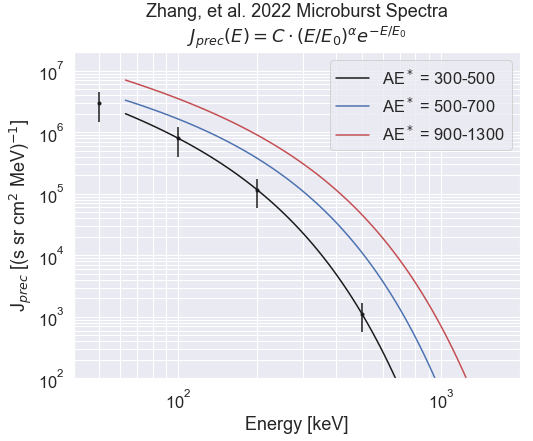

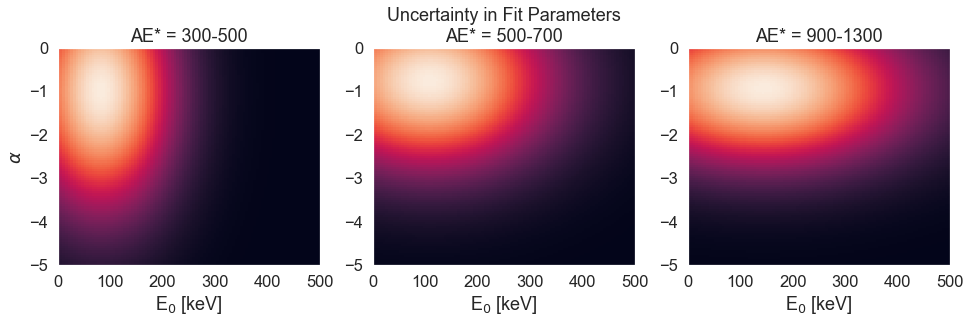

In [2]:
runList = Api.get_run_list()
PAlist  = Api.get_PA_list()

profiles = Api.get_all_ionization_profiles()
profiles[:, 0, 11] = np.zeros([500,])


elf = lambda E, E0, alpha, C: C * (E / E0)**alpha * np.exp( -E / E0 )

E = np.logspace(np.log10(63), np.log10(2000), 100)

AE1 = 400;
AE2 = 600;
AE3 = 1100;

E0_1 = 80.8
E0_2 = 106.6
E0_3 = 142.5

alpha1 = -1
alpha2 = -0.77
alpha3 = -0.95

C = lambda AE: 3.3e5 * AE**0.39

S1 = elf(E, E0_1, alpha1,    C(AE1))
S2 = elf(E, E0_2, alpha2, C(AE2))
S3 = elf(E, E0_3, alpha3, C(AE3))

plt.figure(figsize=(8,6)); plt.grid(True, which='both')
plt.loglog(E, S1, 'k', label='AE$^*$ = 300-500');
plt.loglog(E, S2, 'b', label='AE$^*$ = 500-700');
plt.loglog(E, S3, 'r', label='AE$^*$ = 900-1300');

plt.errorbar(runList, elf(runList, 80.8,  -1,  C(AE1)), 
             yerr=5e-1*elf(runList, 80.8,  -1,    C(AE1)), 
             c='k', linestyle='', marker='.')
#plt.errorbar(runList, elf(runList, 106.6, -0.77, C(AE2)), yerr=, 'b.')
#plt.errorbar(runList, elf(runList, 142.5, -0.95, C(AE3)), yerr=, 'r.')

P1 = np.trapz(1e-3 * elf(runList, 80.8,  -1,    C(AE1)), x=runList)
P2 = np.trapz(1e-3 * elf(runList, 106.6, -0.77, C(AE2)), x=runList)
P3 = np.trapz(1e-3 * elf(runList, 142.5, -0.95, C(AE3)), x=runList)

P = [P1, P2, P3]

for i in range(0, 3):
    print("%.3e /cm2/s/sr" % P[i])


plt.xlabel('Energy [keV]');
plt.ylabel('J$_{prec}$ [(s sr cm$^2$ MeV)$^{-1}$]');
plt.ylim([1e2, 2e7]);
plt.title('Zhang, et al. 2022 Microburst Spectra\n$J_{prec}(E) = C\cdot (E/E_0)^{\\alpha} e^{-E/E_0}$');
plt.legend();
plt.xlim([4e1, 2e3]);


print("\n\nf(E)    AE* = 300-500    500-700    900-1300\n")
cand = np.zeros([3,1]);
for item in runList:
    
    cand[0] = elf(item, 80.8, -1, C(AE1))
    cand[1] = elf(item, 106.6, -0.77, C(AE2))
    cand[2] = elf(item, 142.5, -0.95, C(AE3))
    
    cand[cand < 1e-10] = 0
        
    
    print("f(%.0f keV): %.3e    %.3e    %.3e" % (item, cand[0], cand[1], cand[2]))
    
sig_E0 = np.array([0.01, 0.006, 0.005])
sig_al = np.array([1.968, 1.452, 1.274])

# define normalized 2D gaussian
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

x = np.linspace(0, 500, 100)
y = np.linspace(-5, 0, 100)
x, y = np.meshgrid(x, y) # get 2D variables instead of 1D

E0 = [E0_1, E0_2, E0_3]
alpha = [alpha1, alpha2, alpha3]
titles = ['AE* = 300-500', 'AE* = 500-700', 'AE* = 900-1300']

plt.figure(figsize=(16,4))
for i in range(0, 3):
    plt.subplot(1,3,i+1)
    z = gaus2d(x, y, mx=E0[i], my=alpha[i], sx=1/sig_E0[i], sy=sig_al[i])

    plt.pcolormesh(x, y, z);
    
    plt.xlabel('E$_0$ [keV]');
    plt.title(titles[i])
    
plt.subplot(1,3,1)
plt.ylabel(r'$\alpha$');
plt.subplot(1,3,2)
plt.title('Uncertainty in Fit Parameters\nAE* = 500-700');

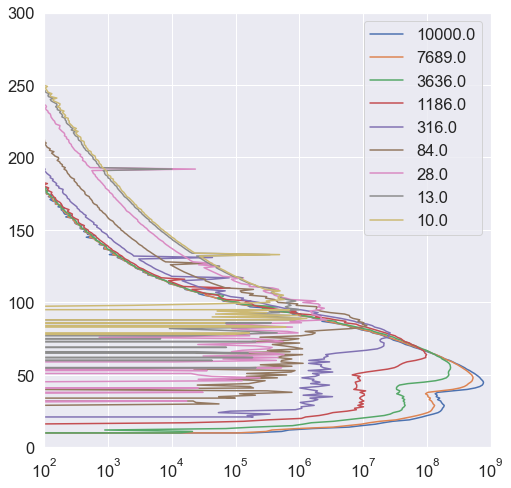

In [6]:
from scipy.interpolate import interp1d

angArr = np.sin(np.deg2rad(PAlist))
colArr = np.nansum(profiles * angArr[np.newaxis, np.newaxis, :], axis=2) * (15*(1 - np.cos(np.deg2rad(70))))

newEval = np.zeros([500, 9])
for i in range(0, 500):
    
    tmp          = interp1d(runList, colArr[i,:], kind='linear', fill_value='extrapolate')
    newEval[i,:] = tmp(xp.flatten())

plt.figure(figsize=(8,8))
plt.plot(newEval, np.linspace(0, 499, 500));
plt.ylim([0, 300]);
plt.xscale('log');
plt.xlim(1e2, 1e9);
plt.legend(np.round(xp.flatten()));

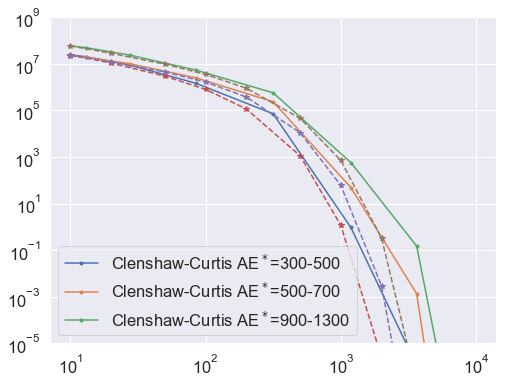

In [7]:
x = np.array([
  [  1.0000],
  [  0.9239],
  [  0.7071],
  [  0.3827],
  [  0.0000],
  [ -0.3827],
  [ -0.7071],
  [ -0.9239],
  [ -1.0000]])

# [-1, 1] -> [0, 1]
x = x * 0.5 + 0.5;

# [0, 1] -> [1, 4]
x = x * 3 + 1

# [1, 4] -> [10^1, 10^4]
xp = 10**x

w = np.array([
  [ 0.0159], 
  [ 0.1462],
  [ 0.2794],
  [ 0.3617],
  [ 0.3937],
  [ 0.3617],
  [ 0.2794],
  [ 0.1462],
  [ 0.0159]])


B0 = np.interp(xp, runList, elf(runList, 80.8,  -1,    C(AE1)))
B1 = np.interp(xp, runList, elf(runList, 106.6, -0.77, C(AE2)))
B2 = np.interp(xp, runList, elf(runList, 142.5, -0.95, C(AE3)))

Bs = [B0, B1, B2]

plt.figure(figsize=(8,6))
plt.loglog(xp, B0, '.-', label='Clenshaw-Curtis AE$^*$=300-500')
plt.loglog(xp, B1, '.-', label='Clenshaw-Curtis AE$^*$=500-700')
plt.loglog(xp, B2, '.-', label='Clenshaw-Curtis AE$^*$=900-1300')

plt.loglog(runList, elf(runList, 80.8,  -1,    C(AE1)), '*--', label=None);
plt.loglog(runList, elf(runList, 106.6, -0.77, C(AE2)), '*--', label=None);
plt.loglog(runList, elf(runList, 142.5, -0.95, C(AE3)), '*--', label=None); 

#plt.xlim(1e1, 1e3)
plt.ylim(1e-5, 1e9)

plt.legend();

# Monte Carlo Simulation

Over input space (E$_0$, $\alpha$, AE$^*$) with ionization profile $I(h)$ output.

Spectral profile

$$J_{prec}(E) = C\cdot \left(\frac{E}{E_0}\right)^\alpha~e^{-E/E_0}$$

If we want to quantify the local uncertainty in $J(E; E_0, \alpha, C)$, we can write

$$\delta J(E) = \sqrt{\left(\frac{\delta J}{\delta E_0} \delta E_0\right)^2 + \left(\frac{\delta J}{\delta \alpha}\delta\alpha\right)^2 + \left(\frac{\delta J}{\delta C}\delta C\right)^2}$$

where each term is

$$\frac{\delta J}{\delta E_0} = \frac{E^\alpha}{E_0^{\alpha+1}}e^{-E/E_0}$$

$$\frac{\delta J}{\delta \alpha} = \left(\frac{E}{E_0}\right)^\alpha \log \frac{E}{E_0} e^{-E/E_0}$$

$$\frac{\delta J}{\delta C} = \left(\frac{E}{E_0}\right)^\alpha e^{-E/E_0}$$

Combining these yields

$$\delta J = \left(\frac{E}{E_0}\right)^{\alpha} e^{-E/E_0} \sqrt{ \left(\frac{1}{E_0}\delta E_0\right)^2 + \left( \log \frac{E}{E_0} \delta\alpha \right)^2 + \left(\delta C\right)^2 } $$

Which we can use in the following formulation:

$$J \pm \delta J = \left(\frac{E}{E_0}\right)^{\alpha} e^{-E/E_0} \left(1 \pm \sqrt{ \left(\frac{1}{E_0}\delta E_0\right)^2 + \left( \log \frac{E}{E_0} \delta\alpha \right)^2 + \left(\delta C\right)^2 } \right)$$

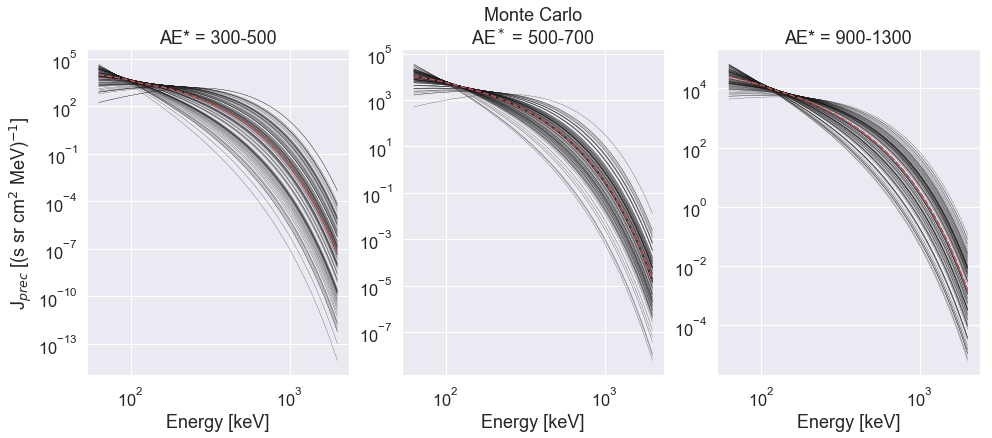

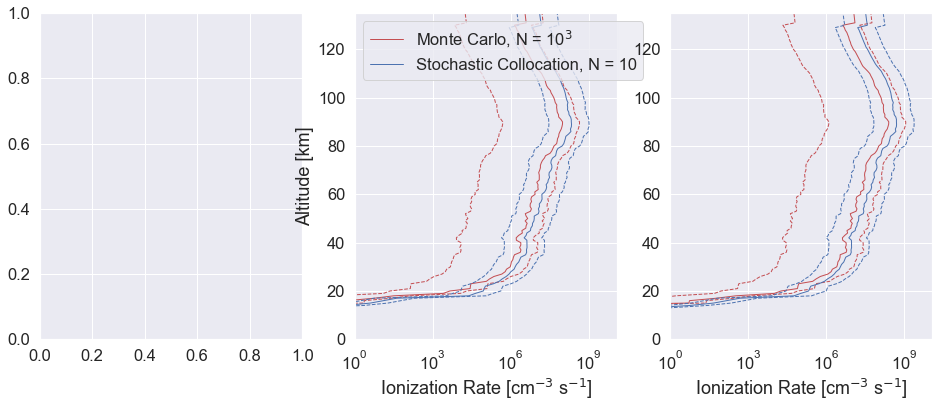

In [53]:
plt.figure(1, figsize=(16,6)); plt.grid(True, which='both')
plt.figure(2, figsize=(16,6)); plt.grid(True, which='both')

Nsamples = 1e2

AElow  = [300, 500, 900]
AEhigh = [500, 700, 1300]
for i in range(0, 3):
    plt.figure(1)
    plt.subplot(1,3,i+1)
    
    # Pick a random AE* within the range
    AEstar = np.random.rand() * (AEhigh[i] - AElow[i]) + AElow[i]
    
    # Calculate integral flux from power law fit at a given AE*
    meanC = 3.3e5 * AEstar**0.39
    varC  = 1e3;
    
    s1 = np.random.randn(int(Nsamples)) * 1e1 * sig_E0[i]**2 + E0[i]
    s2 = np.random.randn(int(Nsamples)) * 0.5e-0 * sig_al[i]**2 + alpha[i] 
    
    s3 = np.random.randn(int(Nsamples)) * 1e1 * varC + meanC
    
    spectra = s3 * (E[:,np.newaxis] / s1)**s2 * np.exp( -E[:,np.newaxis] / s1 )
    
    # Imposed a fixed cumulative flux for consistency
    power = np.trapz(spectra, x=E, axis=0)
    
    spectra = spectra/power * P[i];
    
    M = np.median(spectra, axis=1)
    V = np.std(spectra, axis=1)
    
    plt.loglog(E, spectra, 'k', linewidth=0.25, alpha=1, label='AE$^*$ = 300-500');
    
    #plt.fill_between(E, M-5e-1*V, M+V, alpha=0.5)
    plt.plot(E, M, 'r--')
        
    #plt.errorbar(E, M, yerr=[M+V, M-V], c='r', linestyle='--')
        
    plt.title(titles[i]);
    plt.xlabel('Energy [keV]');
    
    
    plt.figure(2);
    plt.subplot(1,3,i+1);
    
    spectra_coefs = s3 * (runList[:,np.newaxis] / s1)**s2 * np.exp( -runList[:,np.newaxis] / s1 )

    angArr = np.sin(np.deg2rad(PAlist))

    colArr = np.nansum(profiles * angArr[np.newaxis, np.newaxis, :], axis=2) * (15*(1 - np.cos(np.deg2rad(70))))
    
    arr = savgol_filter(np.dot(colArr, spectra_coefs) / 15, 5, 0, axis=0) * 1000/35 * 1e-6
      
    Mi = np.nanmedian(arr, axis=1)
    Vi = np.nanstd(arr, axis=1)
        
    SCarr = np.sum(
    w.flatten() * savgol_filter(np.dot(newEval, Bs[i].flatten()[:,np.newaxis]) / 15, 7, 1, axis=0) * 1000/35 * 1e-6,
    axis=1);

    SCVar = np.sum(
    w.flatten()**2 * savgol_filter(np.dot(newEval, Bs[i].flatten()[:,np.newaxis]) / 15, 7, 1, axis=0) * 1000/35 * 1e-6,
    axis=1);
    
    #plt.semilogx(arr, np.linspace(0, 499, 500), 'k', linewidth=0.1)
    
    plt.semilogx(Mi,    np.linspace(0, 499, 500), 'r-', linewidth=1, label='Monte Carlo, N = 10$^3$')
    #plt.semilogx(Mi+Vi, np.linspace(0, 499, 500), 'r--', linewidth=1, label=None)
    #plt.semilogx(Mi-Vi, np.linspace(0, 499, 500), 'r--', linewidth=1, label=None)
    
    plt.semilogx(0.25e1*1.8*Mi,    np.linspace(0, 499, 500), 'r--', linewidth=1, label=None)
    plt.semilogx(0.25e-1*0.2*Mi,    np.linspace(0, 499, 500), 'r--', linewidth=1, label=None)

    
    plt.semilogx(SCarr, np.linspace(0, 499, 500), 'b-', linewidth=1, label='Stochastic Collocation, N = 10')
    #plt.semilogx(SCarr+SCVar, np.linspace(0, 499, 500), 'b--', linewidth=1, label=None)
    #plt.semilogx(SCarr-SCVar, np.linspace(0, 499, 500), 'b--', linewidth=1, label=None)

    plt.semilogx(2.96*1.6*SCarr, np.linspace(0, 499, 500), 'b--', linewidth=1, label=None)
    plt.semilogx(1/2.96*0.4*SCarr, np.linspace(0, 499, 500), 'b--', linewidth=1, label=None)

    
    #plt.fill_betweenx(np.linspace(0, 499, 500), Mi-3e-3*Vi, Mi+Vi, alpha=0.5)
    
    plt.xlabel('Ionization Rate [cm$^{-3}$ s$^{-1}$]');
    plt.xlim([1e-0, 1.2*np.max(arr)])
    plt.ylim(0, 135)
    
    
plt.figure(1); plt.subplot(1,3,1);
plt.ylabel('J$_{prec}$ [(s sr cm$^2$ MeV)$^{-1}$]');  

plt.subplot(1,3,2)
plt.title("Monte Carlo\nAE$^*$ = 500-700")

plt.figure(2); plt.subplot(1,3,2);
plt.ylabel('Altitude [km]');
plt.legend(loc='upper left');

plt.subplot(1,3,1); plt.cla();

plt.figure(1);
plt.savefig('MCSC_1.png', format='png', bbox_inches='tight')
plt.figure(2);
plt.savefig('MCSC_2.pdf', format='pdf', bbox_inches='tight')

(500,)
(500,)
(500,)


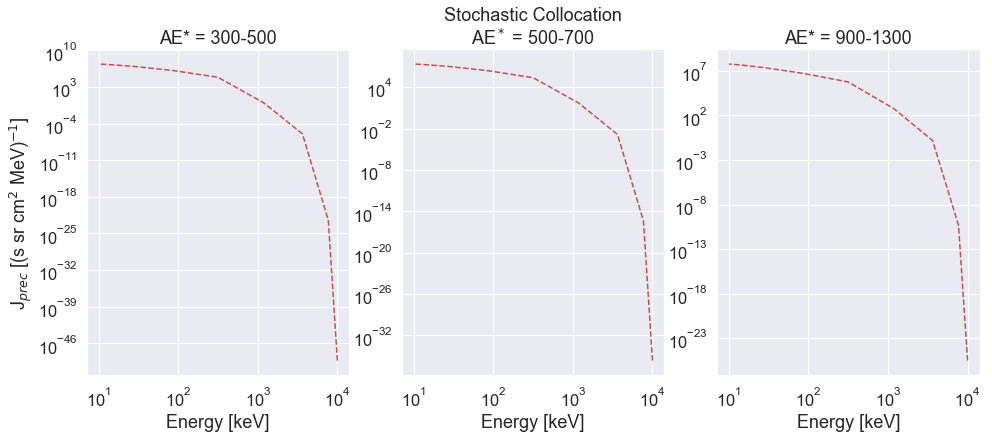

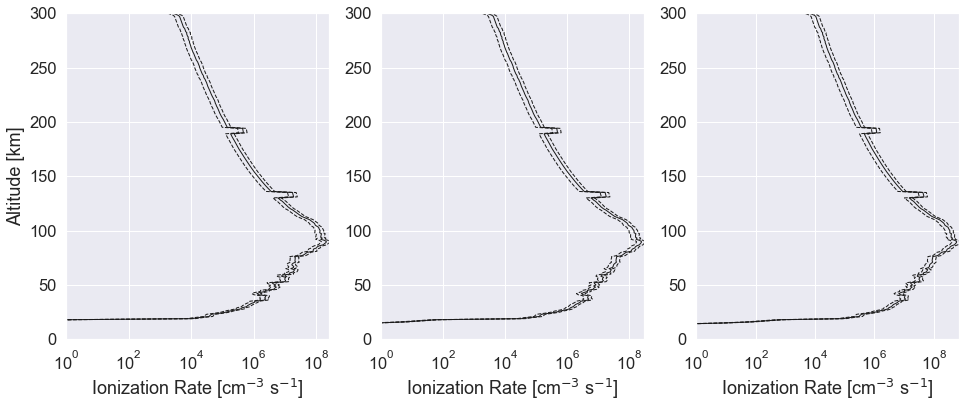

In [106]:
plt.figure(1, figsize=(16,6)); plt.grid(True, which='both')
plt.figure(2, figsize=(16,6)); plt.grid(True, which='both')


Nsamples = 1e1

AElow  = [300, 500, 900]
AEhigh = [500, 7000, 1300]
for i in range(0, 3):
    plt.figure(1)
    plt.subplot(1,3,i+1)

    #plt.loglog(E, spectra, 'k', linewidth=0.1, label='AE$^*$ = 300-500');
    
    plt.plot(xp, Bs[i].flatten(), 'r--')
        
    #plt.errorbar(E, M, yerr=[M+V, M-V], c='r', linestyle='--')
        
    plt.title(titles[i]);
    plt.xlabel('Energy [keV]');
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(2);
    plt.subplot(1,3,i+1);
    
    arr = np.sum(
        w.flatten() * savgol_filter(np.dot(newEval, Bs[i].flatten()[:,np.newaxis]) / 15, 5, 0, axis=0) * 1000/35 * 1e-6,
        axis=1);
    
    Var = np.sum(
        w.flatten()**2 * savgol_filter(np.dot(newEval, Bs[i].flatten()[:,np.newaxis]) / 15, 5, 0, axis=0) * 1000/35 * 1e-6,
        axis=1);

    print(np.shape(arr))
    
    plt.semilogx(arr, np.linspace(0, 499, 500), 'k', linewidth=1)
    plt.semilogx(arr + Var, np.linspace(0, 499, 500), 'k--', linewidth=1)
    plt.semilogx(arr - Var, np.linspace(0, 499, 500), 'k--', linewidth=1)

    #plt.semilogx(Mi, np.linspace(0, 499, 500), 'r--')
    #plt.fill_betweenx(np.linspace(0, 499, 500), Mi-3e-3*Vi, Mi+Vi, alpha=0.5)

    
    plt.xlabel('Ionization Rate [cm$^{-3}$ s$^{-1}$]');
    plt.xlim([1e-0, 1.2*np.max(arr)])
    plt.ylim(0, 300)
    
    
plt.figure(1); plt.subplot(1,3,1);
plt.ylabel('J$_{prec}$ [(s sr cm$^2$ MeV)$^{-1}$]');  


plt.subplot(1,3,2)
plt.title("Stochastic Collocation\nAE$^*$ = 500-700")

plt.figure(2); plt.subplot(1,3,1);
plt.ylabel('Altitude [km]');

10 50
10 50
10 50


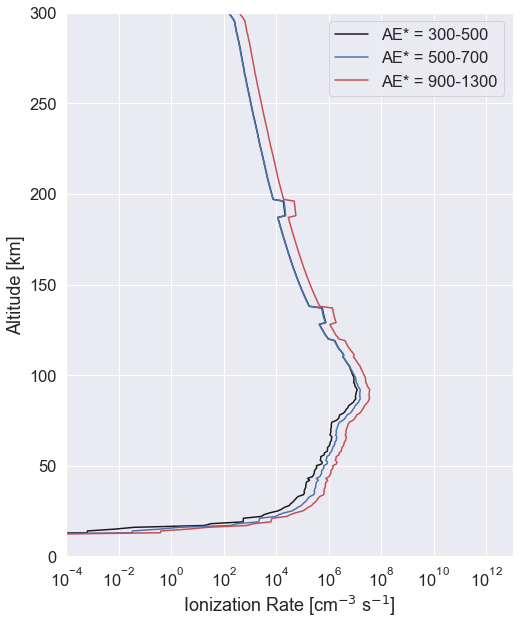

In [4]:
profile = np.zeros([500,3]);
cand = np.zeros([3,1]);
for item in runList:
    
    cand[0] = elf(item, 80.8, -1, C(AE1))
    cand[1] = elf(item, 106.6, -0.77, C(AE2))
    cand[2] = elf(item, 142.5, -0.95, C(AE3))
    
    #cand[cand < 1e-5] = 0
            
    for i in range(0, 3):
        for pa in PAlist:
            prof = Api.get_ionization_profile("mono", item, 1, pa)[0]
            
            if any(np.isnan(prof)):
                print(item, pa)
                continue
                
            profile[:,i] += np.sin(np.deg2rad(pa)) * savgol_filter(cand[i] * prof, 9, 1)/(15*(1-np.cos(np.deg2rad(70))))

plt.figure(figsize=(8,10));
plt.semilogx(profile[:,0]*1000/35 * 1e-6, np.linspace(0, 499, 500), 'k', label='AE* = 300-500');
plt.semilogx(profile[:,1]*1000/35 * 1e-6, np.linspace(0, 499, 500), 'b', label='AE* = 500-700');
plt.semilogx(profile[:,2]*1000/35 * 1e-6, np.linspace(0, 499, 500), 'r', label='AE* = 900-1300');
plt.ylim([0, 300]);

plt.xlabel('Ionization Rate [cm$^{-3}$ s$^{-1}$]');
plt.ylabel('Altitude [km]');
plt.legend();
plt.xlim([1e-4, 1e13]);

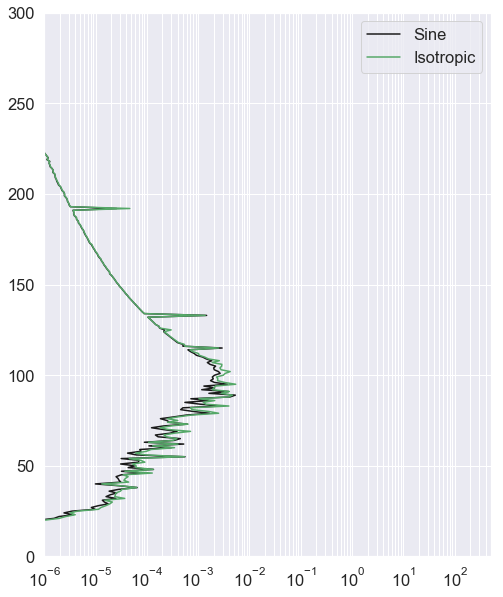

In [5]:
test_prof1 = np.zeros([500,])
test_prof2 = np.zeros([500,])
for item in runList:
    for pa in PAlist:
        
        if item == 10 and pa == 50:
            continue
            
        test_prof1 +=  (1/item)**2 * np.sin(np.deg2rad(pa)) * Api.get_ionization_profile("mono", item, 1, pa)[0] / (15 - 15*np.cos(np.deg2rad(70)))
        test_prof2 +=  (1/item)**2 * Api.get_ionization_profile("mono", item, 1, pa)[0] / 15

plt.figure(figsize=(8,10)); plt.grid(True, which='both')
plt.semilogx(test_prof1 * 1000/35 * 1e-6, np.linspace(0, 499, 500), 'k', label='Sine');
plt.semilogx(test_prof2 * 1000/35 * 1e-6, np.linspace(0, 499, 500), 'g', label='Isotropic');

plt.ylim(0, 300);
plt.xlim(1e-6, 5e2);
plt.legend();